In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [3]:
#setting Gpu for the project
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#getting rid of unwanted format data
data_dir = 'signatures' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))            

In [5]:
#Loading the data for preprocessing
data = tf.keras.utils.image_dataset_from_directory('signatures')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


Found 2640 files belonging to 2 classes.


1 represents original signature 
0 represents forged signature


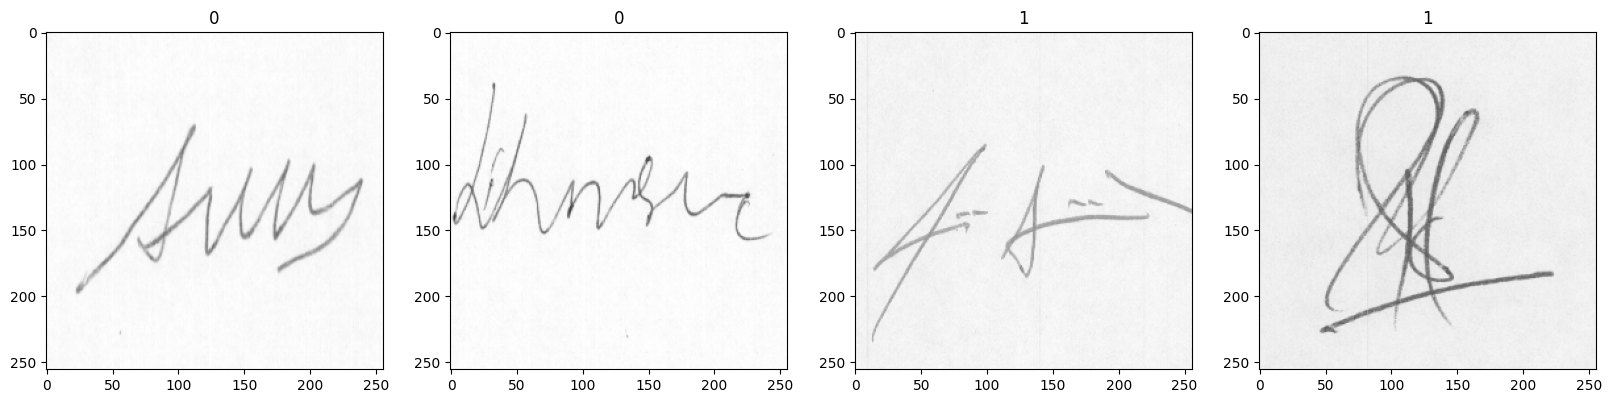

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
print("1 represents original signature \n0 represents forged signature")

In [10]:
#Data Preparation for training and evaluating the model
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [70]:
#creating the CNN model layers using conv2d ,maxpooling,dense 
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [71]:
model.compile('Adamax', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 30, 30, 16)     

In [60]:
logdir='adamax'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
58/58 [==============================] - 15s 104ms/step - loss: 0.8188 - accuracy: 0.5129 - val_loss: 0.6953 - val_accuracy: 0.4902
Epoch 2/25
58/58 [==============================] - 6s 98ms/step - loss: 0.6928 - accuracy: 0.5032 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 3/25
58/58 [==============================] - 6s 99ms/step - loss: 0.6895 - accuracy: 0.5350 - val_loss: 0.6838 - val_accuracy: 0.5039
Epoch 4/25
58/58 [==============================] - 6s 101ms/step - loss: 0.6810 - accuracy: 0.5867 - val_loss: 0.6732 - val_accuracy: 0.6094
Epoch 5/25
58/58 [==============================] - 6s 103ms/step - loss: 0.6597 - accuracy: 0.6428 - val_loss: 0.6351 - val_accuracy: 0.6895
Epoch 6/25
58/58 [==============================] - 6s 100ms/step - loss: 0.6169 - accuracy: 0.6783 - val_loss: 0.5775 - val_accuracy: 0.7090
Epoch 7/25
58/58 [==============================] - 6s 98ms/step - loss: 0.5800 - accuracy: 0.7037 - val_loss: 0.5816 - val_accuracy: 0.6914
Epoch 8/

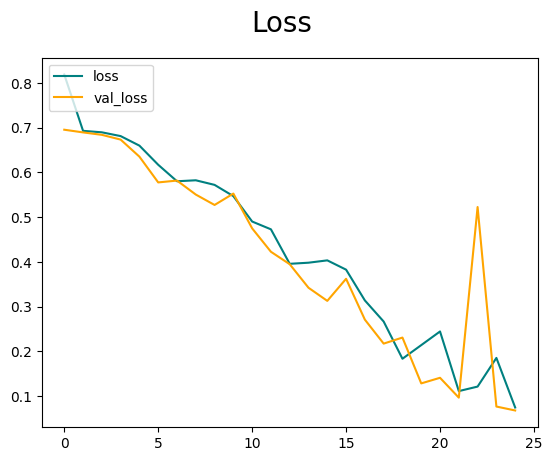

In [61]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

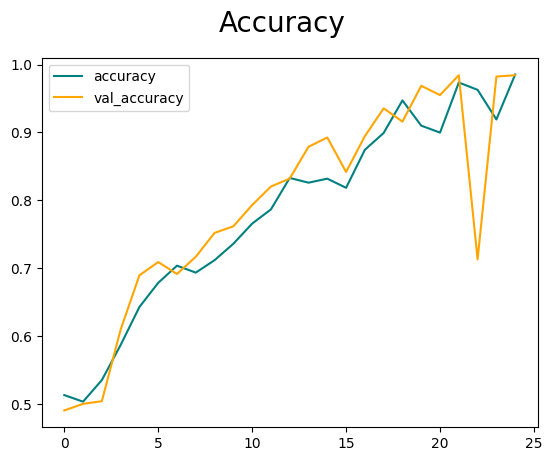

In [62]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [64]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(f' Precision: {pre.result()}, Recall: {re.result()}, Accuracy: {acc.result()}')

1/1 [==============================] - 0s 24ms/step
 precision: 0.9848484992980957, recall: 0.9923664331436157, accuracy: 0.98828125


In [65]:
model.save(os.path.join('models','adamax2.h5'))

input image


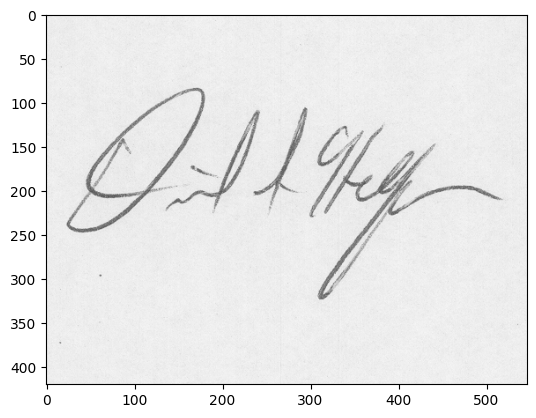

preprocessed image


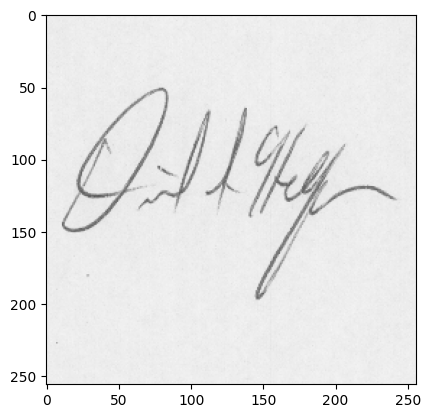

1/1 [==============================] - 0s 51ms/step
Predicted class is original


In [72]:
#testing the model
new_model=load_model("models/adamax2.h5")
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('signatures/full_org/original_10_24.png')
print("input image")
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
print("preprocessed image")
plt.show()
#prediction
predictions = model.predict(np.expand_dims(resize/255, 0))
#printing the predictions
if predictions > 0.5: 
    print(f'Predicted class is original')
else:
    print(f'Predicted class is forged')

